<a href="https://colab.research.google.com/github/Cesare-Caputo/RL-stuff/blob/main/rl_cma_maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import scipy.integrate as scp
import copy
import numpy.random as rnd
import time
import gym

In [ ]:
!pip3 install box2d-py

     |████████████████████████████████| 448 kB 14.3 MB/s 


In [ ]:
import gym
env = gym.make('LunarLander-v2')

AttributeError: ignored

#torchnet

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy as np

class BaseModel:
    def get_weight(self):
        weight = []
        for param in self.parameters():
            weight.append(param.data.numpy().flatten())
        weight = np.concatenate(weight, 0)
        return weight

    def set_weight(self, solution):
        offset = 0
        for param in self.parameters():
            param_shape = param.data.numpy().shape
            param_size = np.prod(param_shape)
            src_param = solution[offset: offset + param_size]
            if len(param_shape) > 1:
                src_param = src_param.reshape(param_shape)
            param.data = torch.FloatTensor(src_param)
            offset += param_size
        assert offset == len(solution)

class StandardFCNet(nn.Module, BaseModel):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(StandardFCNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = Variable(torch.FloatTensor(x))
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

#cma-es

In [ ]:
!pip install cma

     |████████████████████████████████| 249 kB 4.3 MB/s 


In [ ]:
import gym
import torch
import numpy as np
import multiprocessing as mp
import os
import pickle
import sys
import time
import logging
import cma
import argparse

def _makedir(name):
    if not os.path.exists(name):
        os.makedirs(name)

def get_logger():
    _makedir('log')
    _makedir('data')
    logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s: %(message)s')
    logger = logging.getLogger('MAIN')
    logger.setLevel(logging.DEBUG)
    return logger

class Task:

    def __init__(self, envname, hidden_size, max_steps, target, pop_size, reps, test_reps, weight_decay, noise_std, sigma):

        self.task = envname
        self.env_fn = lambda: gym.make(self.task)
        self.repetitions = reps
        self.test_repetitions = test_reps
        env = self.env_fn()
        #self.env = env
        self.action_dim = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.reward_to_fitness = lambda r: r

        self.max_steps = max_steps
        self.pop_size = pop_size

        self.num_workers = mp.cpu_count()

        self.action_clip = lambda a: np.clip(a, -1, 1)
        self.target = target

        self.hidden_size = hidden_size
        self.model_fn = lambda: StandardFCNet(self.state_dim, self.action_dim, self.hidden_size)
        model = self.model_fn()
        self.initial_weight = model.get_weight()
        self.weight_decay = weight_decay
        self.action_noise_std = noise_std
        self.sigma = sigma
        self.tag = 'CMA-%d' % (hidden_size)

class BaseModel:
    def get_weight(self):
        weight = []
        for param in self.parameters():
            weight.append(param.data.numpy().flatten())
        weight = np.concatenate(weight, 0)
        return weight

    def set_weight(self, solution):
        offset = 0
        for param in self.parameters():
            param_shape = param.data.numpy().shape
            param_size = np.prod(param_shape)
            src_param = solution[offset: offset + param_size]
            if len(param_shape) > 1:
                src_param = src_param.reshape(param_shape)
            param.data = torch.FloatTensor(src_param)
            offset += param_size
        assert offset == len(solution)

class Normalizer:
    def __init__(self, filter_mean=True):
        self.m = 0
        self.v = 0
        self.n = 0.
        self.filter_mean = filter_mean

    def state_dict(self):
        return {'m': self.m,
                'v': self.v,
                'n': self.n}

    def load_state_dict(self, saved):
        self.m = saved['m']
        self.v = saved['v']
        self.n = saved['n']

    def __call__(self, o):
        self.m = self.m * (self.n / (self.n + 1)) + o * 1 / (1 + self.n)
        self.v = self.v * (self.n / (self.n + 1)) + (o - self.m) ** 2 * 1 / (1 + self.n)
        self.std = (self.v + 1e-6) ** .5  # std
        self.n += 1
        if self.filter_mean:
            o_ = (o - self.m) / self.std
        else:
            o_ = o / self.std
        return o_

class StaticNormalizer:
    def __init__(self, o_size):
        self.offline_stats = SharedStats(o_size)
        self.online_stats = SharedStats(o_size)

    def __call__(self, o_):
        o = torch.FloatTensor([o_] if np.isscalar(o_) else o_)
        self.online_stats.feed(o)
        if self.offline_stats.n[0] == 0:
            return o_
        std = (self.offline_stats.v + 1e-6) ** .5
        o = (o - self.offline_stats.m) / std
        o = o.numpy()
        if np.isscalar(o_):
            o = np.asscalar(o)
        else:
            o = o.reshape(o_.shape)
        return o

class SharedStats:
    def __init__(self, o_size):
        self.m = torch.zeros(o_size)
        self.v = torch.zeros(o_size)
        self.n = torch.zeros(1)
        self.m.share_memory_()
        self.v.share_memory_()
        self.n.share_memory_()

    def feed(self, o):
        n = self.n[0]
        new_m = self.m * (n / (n + 1)) + o / (n + 1)
        self.v.copy_(self.v * (n / (n + 1)) + (o - self.m) * (o - new_m) / (n + 1))
        self.m.copy_(new_m)
        self.n.add_(1)

    def zero(self):
        self.m.zero_()
        self.v.zero_()
        self.n.zero_()

    def load(self, stats):
        self.m.copy_(stats.m)
        self.v.copy_(stats.v)
        self.n.copy_(stats.n)

    def merge(self, B):
        A = self
        n_A = self.n[0]
        n_B = B.n[0]
        n = n_A + n_B
        delta = B.m - A.m
        m = A.m + delta * n_B / n
        v = A.v * n_A + B.v * n_B + delta * delta * n_A * n_B / n
        v /= n
        self.m.copy_(m)
        self.v.copy_(v)
        self.n.add_(B.n)

    def state_dict(self):
        return {'m': self.m.numpy(),
                'v': self.v.numpy(),
                'n': self.n.numpy()}

    def load_state_dict(self, saved):
        self.m = torch.FloatTensor(saved['m'])
        self.v = torch.FloatTensor(saved['v'])
        self.n = torch.FloatTensor(saved['n'])

def fitness_shift(x):
    x = np.asarray(x).flatten()
    ranks = np.empty(len(x))
    ranks[x.argsort()] = np.arange(len(x))
    ranks /= (len(x) - 1)
    ranks -= .5
    return ranks

class Worker(mp.Process):
    def __init__(self, id, task_q, result_q, stop):
        mp.Process.__init__(self)
        self.id = id
        self.task_q = task_q
        self.result_q = result_q
        self.stop = stop

    def run(self):
        np.random.seed()
        while not self.stop.value:
            if self.task_q.empty():
                continue
            id, solution = self.task_q.get()
            fitness, steps = self.evalfun(solution)
            self.result_q.put([id, fitness, steps])

class Evaluator:

    def __init__(self, config, state_normalizer):
        self.model = config.model_fn()
        self.repetitions = config.repetitions
        self.env = config.env_fn()
        self.state_normalizer = state_normalizer
        self.config = config

    def eval(self, solution):
        self.model.set_weight(solution)
        rewards = []
        steps = []
        for i in range(self.repetitions):
            reward, step = self.single_run()
            rewards.append(reward)
            steps.append(step)
        return -np.mean(rewards), np.sum(steps)

    def single_run(self):
        state = self.env.reset()
        total_reward = 0
        steps = 0
        while True:
            state = self.state_normalizer(state)
            action = self.model(np.stack([state])).data.numpy().flatten()
            action += np.random.randn(len(action)) * self.config.action_noise_std
            action = self.config.action_clip(action)
            state, reward, done, info = self.env.step(action)
            steps += 1
            total_reward += reward
            if done:
                return total_reward, steps


class CMAWorker(Worker):

    def __init__(self, id, state_normalizer, task_q, result_q, stop, config):
        Worker.__init__(self, id, task_q, result_q, stop)
        self.evalfun = Evaluator(config, state_normalizer).eval

def train(config, logger):
    task_queue = mp.SimpleQueue()
    result_queue = mp.SimpleQueue()
    stop = mp.Value('i', False)
    stats = SharedStats(config.state_dim)
    normalizers = [StaticNormalizer(config.state_dim) for _ in range(config.num_workers)]
    for normalizer in normalizers:
        normalizer.offline_stats.load(stats)

    workers = [CMAWorker(id, normalizers[id], task_queue, result_queue, stop, config) for id in range(config.num_workers)]
    for w in workers: w.start()

    opt = cma.CMAOptions()
    opt['tolfun'] = -config.target
    opt['popsize'] = config.pop_size
    opt['verb_disp'] = 0
    opt['verb_log'] = 0
    opt['maxiter'] = sys.maxsize
    es = cma.CMAEvolutionStrategy(config.initial_weight, config.sigma, opt)

    total_steps = 0
    initial_time = time.time()
    training_rewards = []
    training_steps = []
    training_timestamps = []
    test_mean, test_std = test(config, config.initial_weight, stats)
    logger.info('total steps %8d, %+4.0f(%+4.0f)' % (total_steps, test_mean, test_std))
    training_rewards.append(test_mean)
    training_steps.append(0)
    training_timestamps.append(0)
    while True:
        solutions = es.ask()
        for id, solution in enumerate(solutions):
            task_queue.put((id, solution))
        while not task_queue.empty():
            continue
        result = []
        while len(result) < len(solutions):
            if result_queue.empty():
                continue
            result.append(result_queue.get())
        result = sorted(result, key=lambda x: x[0])
        total_steps += np.sum([r[2] for r in result])
        cost = [r[1] for r in result]
        best_solution = solutions[np.argmin(cost)]
        elapsed_time = time.time() - initial_time
        test_mean, test_std = test(config, best_solution, stats)
        best = -np.min(cost)
        logger.info('total steps = %8d    test = %+4.0f (%4.0f)    best = %+4.0f (%+4.0f)    elapased time = %4.0f sec' %
            (total_steps, test_mean, test_std, best, config.target, elapsed_time))
        training_rewards.append(test_mean)
        training_steps.append(total_steps)
        training_timestamps.append(elapsed_time)
        #with open('data/%s-best_solution_%s.bin' % (TAG, config.task), 'wb') as f: # XXX gets stuck
        #    pickle.dump(solutions[np.argmin(result)], f)
        if best > config.target:
            logger.info('Best score of %f exceeds target %f' % (best, config.target))
            break
        if config.max_steps and total_steps > config.max_steps:
            logger.info('Maximum number of steps exceeded')
            stop.value = True
            break

        cost = fitness_shift(cost)
        es.tell(solutions, cost)
        # es.disp()
        for normalizer in normalizers:
            stats.merge(normalizer.online_stats)
            normalizer.online_stats.zero()
        for normalizer in normalizers:
            normalizer.offline_stats.load(stats)

    stop.value = True
    for w in workers: w.join()
    return [training_rewards, training_steps, training_timestamps]

def test(config, solution, stats):
    normalizer = StaticNormalizer(config.state_dim)
    normalizer.offline_stats.load_state_dict(stats.state_dict())
    evaluator = Evaluator(config, normalizer)
    evaluator.model.set_weight(solution)
    rewards = []
    for i in range(config.test_repetitions):
        reward, _ = evaluator.single_run()
        rewards.append(reward)
    return np.mean(rewards), np.std(rewards) / config.repetitions

def multi_runs(task, logger, runs=1):
    if not os.path.exists('log'):
        os.makedirs('log')
    fh = logging.FileHandler('log/%s-%s.txt' % (task.tag, task.task))
    fh.setLevel(logging.DEBUG)
    logger.addHandler(fh)

    stats = []
    for run in range(runs):
        logger.info('Run %3d/%3d' % (run+1, runs))
        stats.append(train(task, logger))
        with open('data/%s-stats-%s.bin' % (task.tag, task.task), 'wb') as f:
            pickle.dump(stats, f)

#mazelab

In [ ]:
### including all in one code cell
import gym
from gym.spaces import Box
from gym.spaces import Discrete

from dataclasses import dataclass
from dataclasses import field
@dataclass
class Object:
    r"""Defines an object with some of its properties.

    An object can be an obstacle, free space or food etc. It can also have properties like impassable, positions.

    """
    name: str
    value: int
    rgb: tuple
    impassable: bool
    positions: list = field(default_factory=list)


from abc import ABC
from abc import abstractmethod

from collections import namedtuple
import numpy as np

#from .object import Object


class BaseMaze(ABC):
    def __init__(self, **kwargs):
        objects = self.make_objects()
        assert all([isinstance(obj, Object) for obj in objects])
        self.objects = namedtuple('Objects', map(lambda x: x.name, objects), defaults=objects)()

        for key, value in kwargs.items():
            setattr(self, key, value)

    @property
    @abstractmethod
    def size(self):
        r"""Returns a pair of (height, width). """
        pass

    @abstractmethod
    def make_objects(self):
        r"""Returns a list of defined objects. """
        pass

    def _convert(self, x, name):
        for obj in self.objects:
            pos = np.asarray(obj.positions)
            x[pos[:, 0], pos[:, 1]] = getattr(obj, name, None)
        return x

    def to_name(self):
        x = np.empty(self.size, dtype=object)
        return self._convert(x, 'name')

    def to_value(self):
        x = np.empty(self.size, dtype=int)
        return self._convert(x, 'value')

    def to_rgb(self):
        x = np.empty((*self.size, 3), dtype=np.uint8)
        return self._convert(x, 'rgb')

    def to_impassable(self):
        x = np.empty(self.size, dtype=bool)
        return self._convert(x, 'impassable')

    def __repr__(self):
        return f'{self.__class__.__name__}{self.size}'


from collections import namedtuple


VonNeumannMotion = namedtuple('VonNeumannMotion',
                              ['north', 'south', 'west', 'east'],
                              defaults=[[-1, 0], [1, 0], [0, -1], [0, 1]])


MooreMotion = namedtuple('MooreMotion',
                         ['north', 'south', 'west', 'east',
                          'northwest', 'northeast', 'southwest', 'southeast'],
                         defaults=[[-1, 0], [1, 0], [0, -1], [0, 1],
                                   [-1, -1], [-1, 1], [1, -1], [1, 1]])

from abc import ABC
from abc import abstractmethod

import numpy as np
import gym
from gym.utils import seeding
from PIL import Image


class BaseEnv(gym.Env, ABC):
    metadata = {'render.modes': ['human', 'rgb_array'],
                'video.frames_per_second' : 3}
    reward_range = (-float('inf'), float('inf'))

    def __init__(self):
        self.viewer = None
        self.seed()

    @abstractmethod
    def step(self, action):
        pass

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def get_image(self):
        pass

    def render(self, mode='human', max_width=500):
        img = self.get_image()
        img = np.asarray(img).astype(np.uint8)
        img_height, img_width = img.shape[:2]
        ratio = max_width/img_width
        img = Image.fromarray(img).resize([int(ratio*img_width), int(ratio*img_height)])
        img = np.asarray(img)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            from gym.envs.classic_control.rendering import SimpleImageViewer
            if self.viewer is None:
                self.viewer = SimpleImageViewer()
            self.viewer.imshow(img)

            return self.viewer.isopen

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

from dataclasses import dataclass


@dataclass
# class DeepMindColor:
#     obstacle = (160, 160, 160)
#     free = (224, 224, 224)
#     agent = (51, 153, 255)
#     goal = (51, 255, 51)
#     button = (102, 0, 204)
#     interruption = (255, 0, 255)
#     box = (0, 102, 102)
#     lava = (255, 0, 0)
#     water = (0, 0, 255)

## this one is better for smaller maze and david silver style
class color:
    obstacle = (0, 0, 0)
    free = (255, 255, 255)
    agent = (255, 51, 51)
    goal = (51, 255, 51)
    button = (102, 0, 204)
    interruption = (255, 0, 255)
    box = (0, 102, 102)
    lava = (255, 0, 0)
    water = (0, 0, 255)


import numpy as np


def random_maze(width=81, height=51, complexity=.75, density=.75):
    r"""Generate a random maze array.

    It only contains two kind of objects, obstacle and free space. The numerical value for obstacle
    is ``1`` and for free space is ``0``.

    Code from https://en.wikipedia.org/wiki/Maze_generation_algorithm
    """
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1])))
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2)))
    # Build actual maze
    Z = np.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = np.random.randint(0, shape[1]//2 + 1) * 2, np.random.randint(0, shape[0]//2 + 1) * 2
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[np.random.randint(0, len(neighbours))]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_

    return Z.astype(int)



class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape

    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal


class Env(BaseEnv):
    def __init__(self):
        super().__init__()

        self.maze = Maze()
        self.motions = VonNeumannMotion()

        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))

    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]

        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}

    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()

    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable

    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out

    def get_image(self):
        return self.maze.to_rgb()

#load prev maze

In [ ]:
x = np.load("stupid-maze.npy")
print(x)

[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]


In [ ]:
start_idx = [[4, 1]]
goal_idx = [[49, 48]]
env_id = 'RandomMaze50by50-v3'


gym.envs.register(id=env_id, entry_point=Env, max_episode_steps=1000)


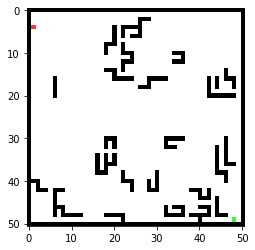

In [ ]:
env = gym.make(env_id)
obs = env.reset()
screen = env.render(mode = 'rgb_array', max_width = 51)
plt.imshow(screen)

In [ ]:
# default hyperparameters
nhid = 8
target = -np.inf
max_steps = int(2e3)
pop_size = 64
reps = 10
test_reps = 10
weight_decay = .005
noise_std = 0
sigma = 1

In [ ]:
env.action_space.n

4

In [ ]:
task = Task('RandomMaze50by50-v1', nhid, max_steps, target, pop_size, reps, test_reps,
        weight_decay, noise_std, sigma)

logger = get_logger()

p = mp.Process(target=multi_runs, args=(task,logger))

p.start()
p.join()

##sb approach


In [ ]:
!apt install swig
!pip install stable-baselines3[extra]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 2s (492 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 155514 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking 

In [ ]:
import gym
import numpy as np
import cma
from collections import OrderedDict
from stable_baselines3 import A2C


def flatten(params):
    """
    :param params: (dict)
    :return: (np.ndarray)
    """
    params_ = []
    for key in params.keys():
        params_.append(params[key].flatten())
    return np.concatenate(params_)

def to_dict(flat_vec, params):
    """
    :param flat_vec: (np.ndarray)
    :param params: (OrderedDict)
    :return: (OrderedDict)
    """
    params_ = OrderedDict()
    start_idx = 0
    for key in params.keys():
        n_elem = params[key].size
        params_[key] = flat_vec[start_idx:start_idx + n_elem].reshape(params[key].shape)
        start_idx += n_elem
    return params_

def filter_policy_params(params):
    """
    Include only variables with "/pi/" (policy) or "/shared" (shared layers)
    in their name: Only these ones affect the action.
    :param params: (OrderedDict)
    :return: (OrderedDict)
    """
    return OrderedDict((key, value) for key, value in params.items()
                        if ("/pi/" in key or "/shared" in key))


def evaluate(env, model):
    """
    Return mean fitness (negative sum of episodic rewards)
    for given model.
    :param env: (gym.Env)
    :param model: (RL Model)
    :return: (float)
    """
    episode_rewards = []
    for _ in range(10):
        reward_sum = 0
        done = False
        obs = env.reset()
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            reward_sum += reward
        episode_rewards.append(reward_sum)
    return - np.mean(episode_rewards)



In [ ]:
from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)


In [ ]:
tb_dir ="./50mazev1"

In [ ]:
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

In [ ]:
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [ ]:
# Create RL model with a small policy network
model1 = A2C('MlpPolicy', env, ent_coef=0.0, learning_rate=0.001, policy_kwargs={'net_arch': [8]},  verbose=1, tensorboard_log="/tmp/50mazev0/")

# Use RL actor-critic policy gradient updates to
# find good initial parameters
model1.learn(total_timesteps=100000, callback=callback)




In [ ]:
# Create RL model with a small policy network
from stable_baselines3 import PPO
model2 = PPO('MlpPolicy', env,  learning_rate=0.001, policy_kwargs={'net_arch': [8]},  verbose=1, tensorboard_log="/tmp/50mazev0/")

# Use RL actor-critic policy gradient updates to
# find good initial parameters
model2.learn(total_timesteps=100000, callback=callback)


In [ ]:
# find good initial parameters
model2.learn(total_timesteps=100000, callback=callback)

Logging to /tmp/50mazev0/PPO_2
Num timesteps: 648
Best mean reward: -67.60 - Last mean reward per episode: -102.18
Num timesteps: 1648
Best mean reward: -67.60 - Last mean reward per episode: -100.19
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -116     |
| time/              |          |
|    fps             | 518      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
Num timesteps: 2648
Best mean reward: -67.60 - Last mean reward per episode: -99.60
Num timesteps: 3648
Best mean reward: -67.60 - Last mean reward per episode: -99.55
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -131        |
| time/                   |             |
|    fps                  | 460         |
|    iterations           | 2           

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/50mazev0/

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

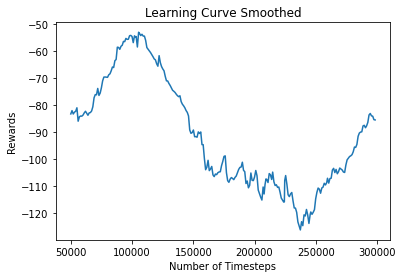

In [ ]:
plot_results(log_dir)

In [ ]:
import imageio
from google.colab import files

In [ ]:
images = []
obs = model.env.reset()
img = env.render(mode='rgb_array', max_width = 51)
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = env.render(mode='rgb_array', max_width = 51)

imageio.mimsave('easy_maze2d_a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=15)
files.download("easy_maze2d_a2c.gif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

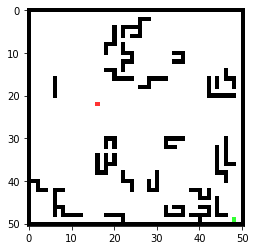

In [ ]:
#### higher quality rendering ####
for i in range(len(images)):
  img = images[i]
  a = plt.imshow(img)
  a.figure.savefig(str(i) + "rl_course_medium_maze_PG2_ok.png")

In [ ]:
years = list(range(len(images)))
imagesg = list()
for y in years:
    imagesg.append(imageio.imread(str(y) + "rl_course_medium_maze_PG2_ok.png"))
imageio.mimsave("medium_maze_evolution_PG2.gif", imagesg,fps = 15)
files.download("medium_maze_evolution_PG2.gif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from typing import Dict
import torch as th
def mutate(params: Dict[str, th.Tensor]) -> Dict[str, th.Tensor]:
    """Mutate parameters by adding normal noise to them"""
    return dict((name, param + th.randn_like(param)) for name, param in params.items())

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
# Include only variables with "policy", "action" (policy) or "shared_net" (shared layers)
# in their name: only these ones affect the action.
# NOTE: you can retrieve those parameters using model.get_parameters() too
mean_params = dict(
    (key, value)
    for key, value in model.policy.state_dict().items()
    if ("policy" in key or "shared_net" in key or "action" in key)
)

# population size of 50 invdiduals
pop_size = 25
# Keep top 10%
n_elite = pop_size // 5
# Retrieve the environment
env = model.get_env()

for iteration in range(3):
    # Create population of candidates and evaluate them
    population = []
    for population_i in range(pop_size):
        candidate = mutate(mean_params)
        # Load new policy parameters to agent.
        # Tell function that it should only update parameters
        # we give it (policy parameters)
        model.policy.load_state_dict(candidate, strict=False)
        # Evaluate the candidate
        fitness, _ = evaluate_policy(model, env)
        population.append((candidate, fitness))
    # Take top 10% and use average over their parameters as next mean parameter
    top_candidates = sorted(population, key=lambda x: x[1], reverse=True)[:n_elite]
    mean_params = dict(
        (
            name,
            th.stack([candidate[0][name] for candidate in top_candidates]).mean(dim=0),
        )
        for name in mean_params.keys()
    )
    mean_fitness = sum(top_candidate[1] for top_candidate in top_candidates) / n_elite
    print(f"Iteration {iteration + 1:<3} Mean top fitness: {mean_fitness:.2f}")
    print(f"Best fitness: {top_candidates[0][1]:.2f}")

Iteration 1   Mean top fitness: -1965.35
Best fitness: -1965.35
Iteration 2   Mean top fitness: -1965.35
Best fitness: -1965.35
Iteration 3   Mean top fitness: -1965.35
Best fitness: -1965.35


In [ ]:
model.load_parameters

AttributeError: ignored

In [ ]:
# Create the Evolution Strategy (ES) object
es = cma.CMAEvolutionStrategy(flatten(policy_params), sigma0=1)

for iteration in range(10):
    # Create population of candidates and evaluate them
    candidates, fitnesses = es.ask(), []
    for candidate in candidates:
        # Load new policy parameters to agent.
        model.load_parameters(to_dict(candidate, policy_params), exact_match=False)
        # Evaluate the agent using stable-baselines predict function
        fitnesses.append(evaluate(model.get_env(), model))
    # CMA-ES update
    es.tell(candidates, fitnesses)
    # Display some training infos
    mean_fitness = np.mean(sorted(fitnesses)[:int(0.1 * len(candidates))])
    print("Iteration {:<3} Mean top 10% reward: {:.2f}".format(iteration, -mean_fitness))

(16_w,33)-aCMA-ES (mu_w=9.4,w_1=19%) in dimension 20861 (seed=253053, Thu Apr 28 13:51:15 2022)


AttributeError: ignored